In [2]:
import sys
import os
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt

import pandas as pd

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd

sys.path.insert(0, "../src/helper")

from landprice_merger import (
    zensus_landprice_merger,
    landprice_neighborhood_merger,
    combine_landprice_with_geodata,
)
from csv_merger import combine_csvs
from principal_component_analysis import combine_PCA_datasets


pd.options.mode.chained_assignment = None

In [3]:
cities = ["Berlin", "Bremen", "Dresden", "Frankfurt_am_Main", "Köln"]

main_path = os.path.join(os.getcwd(), "..")

path_zensus = os.path.join(main_path, "res", "data", "DLR", "2 Zensus")
path_land = os.path.join(main_path, "res", "data", "DLR", "1 Land Prices")
path_neigh = os.path.join(main_path, "res", "data", "DLR", "3 Neighborhoods")


In [4]:
ls_df_cities = []

for i in range(len(cities)):
    
    df_zensus = combine_csvs(str_path=path_zensus)

    gdf_zensus = combine_PCA_datasets(
    df_zensus=df_zensus, str_city=cities[i], str_path=path_zensus
    )

    df_land_prices = combine_csvs(str_path=path_land)

    gdf_landprices = combine_landprice_with_geodata(
        df_landprice=df_land_prices, str_city=cities[i], str_path=path_land
    )

    gdf_landprices_names = landprice_neighborhood_merger(
        gdf_landprice=gdf_landprices, str_city=cities[i], str_path_neigh=path_neigh
    )

    result = zensus_landprice_merger(
    gdf_landprices=gdf_landprices_names, gdf_zensus=gdf_zensus
    )

    result_grouped = result.groupby("Neighborhood_Name").median().reset_index()

    
    land_price_grid = gpd.read_file(path_neigh + "/Neighborhoods_" + cities[i] + ".gpkg")
    result_grouped = result_grouped.merge(land_price_grid, on = ["Neighborhood_Name", "Neighborhood_FID"])
    result_grouped_lm = result_grouped.drop(columns = ["Neighborhood_Name"])

    ls_df_cities.append(result_grouped_lm)


C:\Users\ferdi\AppData\Local\Temp\ipykernel_14072\178601277.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_grouped = result.groupby("Neighborhood_Name").median().reset_index()
C:\Users\ferdi\AppData\Local\Temp\ipykernel_14072\178601277.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_grouped = result.groupby("Neighborhood_Name").median().reset_index()
C:\Users\ferdi\AppData\Local\Temp\ipykernel_14072\178601277.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify nu

### Berlin

In [5]:
df_berlin = ls_df_cities[0].drop(columns = ["geometry", "City_Name", "City_Code", "index_right", "Neighborhood_FID", "District_Name"])

<function matplotlib.pyplot.show(close=None, block=None)>

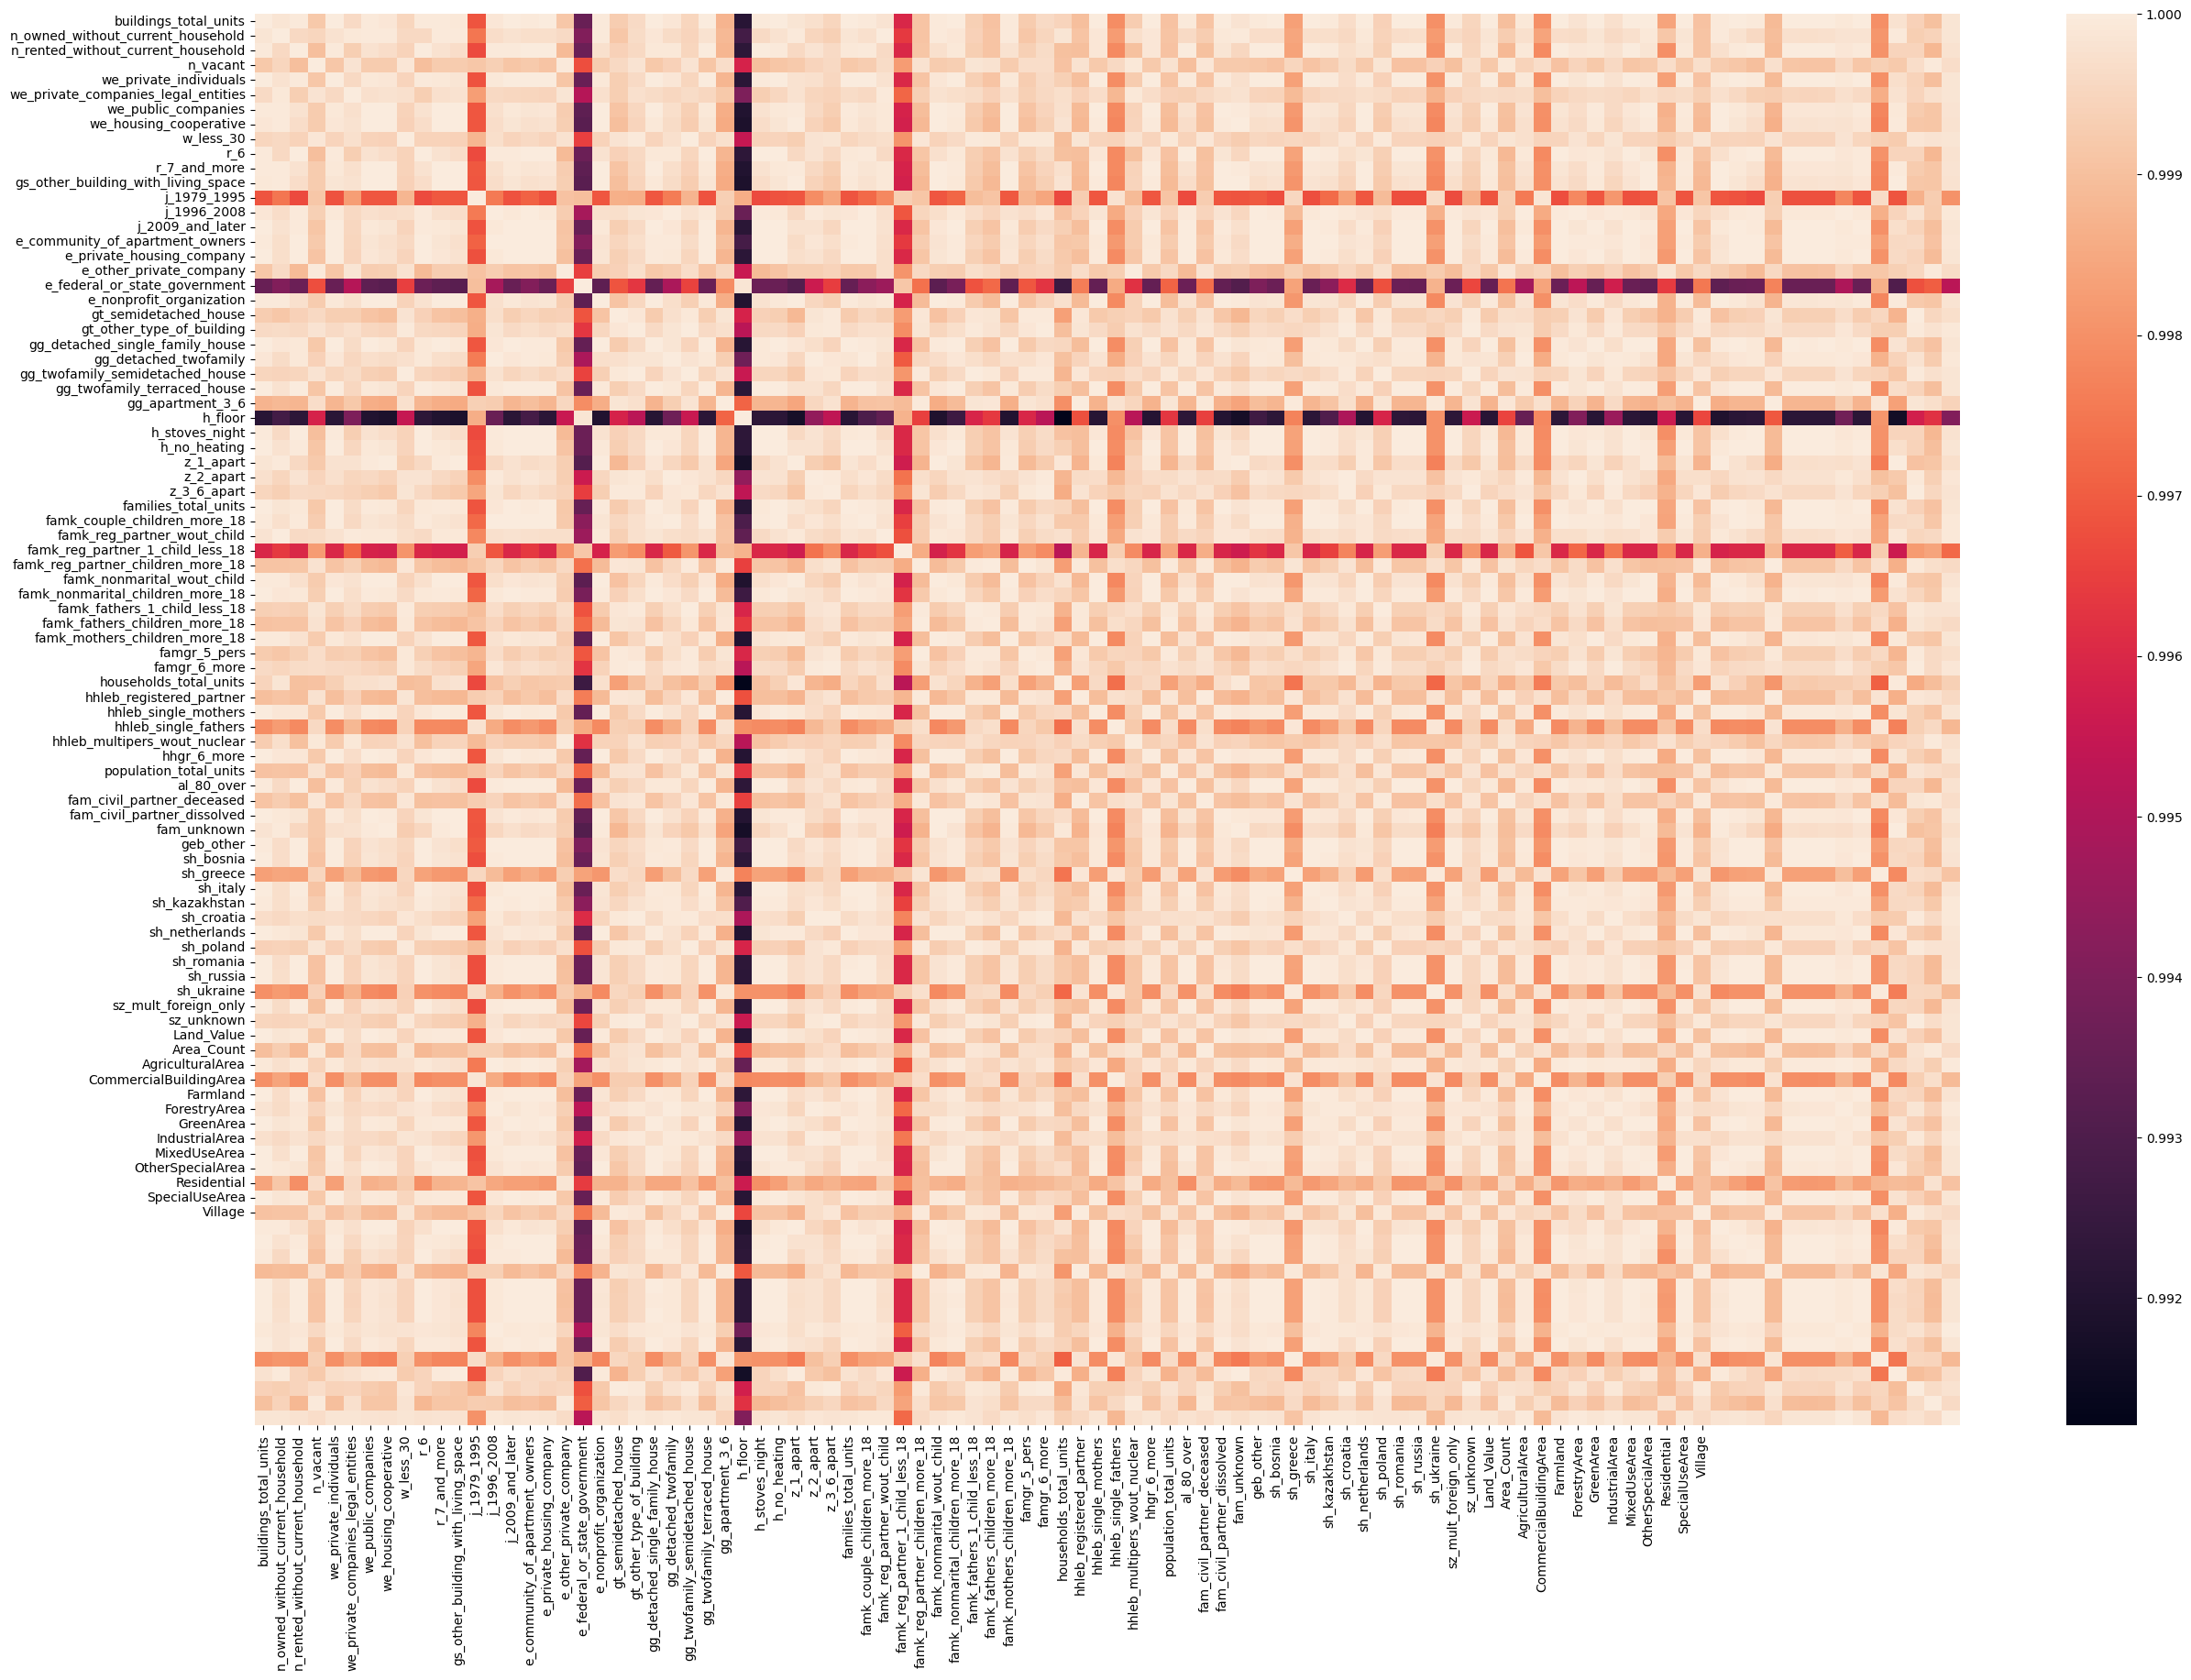

In [6]:
# calculate the correlation matrix
corr = np.corrcoef(df_berlin)


plt.figure(figsize=(30,20))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=df_berlin.columns,
        yticklabels=df_berlin.columns)

plt.show

In [7]:
y = df_berlin["Land_Value"].values.reshape(-1, 1)
X = df_berlin.drop(columns = ["Land_Value"])[["buildings_total_units",
"population_total_units",
"households_total_units",
'Area_Count',
"n_vacant",
"MixedUseArea",
"r_6"]].values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)


In [8]:

X2 = sm.add_constant(X_scaled)
est = sm.OLS(y_scaled, X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     18.09
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           1.29e-13
Time:                        23:29:41   Log-Likelihood:                -97.945
No. Observations:                  96   AIC:                             209.9
Df Residuals:                      89   BIC:                             227.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.359e-16      0.071  -3.32e-15      1.0

In [9]:
regr = linear_model.LinearRegression()
regr.fit(X_scaled, y_scaled)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 [-1.73258228e-16]
Coefficients: 
 [[ 6.47241395 -2.09168661 -4.02919833  0.18768221  0.06868621  0.26530001
   0.06868621]]


In [10]:
scores = cross_val_score(regr, X_scaled, y_scaled, cv = 5)
scores

array([0.53946558, 0.17260855, 0.49256476, 0.74438592, 0.19948849])

In [11]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.43 (+/- 0.43)


### Bremen

In [12]:
df_bremen = ls_df_cities[1].drop(columns = ["geometry", "City_Name", "City_Code", "index_right", "Neighborhood_FID", "District_Name", 
"Neighborhood_Code", "District_Code"])

In [13]:
df_bremen

,buildings_total_units,n_owned_without_current_household,n_rented_without_current_household,n_vacation_and_leisure,n_vacant,we_private_companies_legal_entities,we_public_companies,we_housing_cooperative,gs_dormitory,gs_other_building_with_living_space,...,CommercialBuildingArea,Farmland,ForestryArea,GreenArea,IndustrialArea,MixedUseArea,OtherSpecialArea,Residential,SpecialUseArea,Village
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
84,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<function matplotlib.pyplot.show(close=None, block=None)>

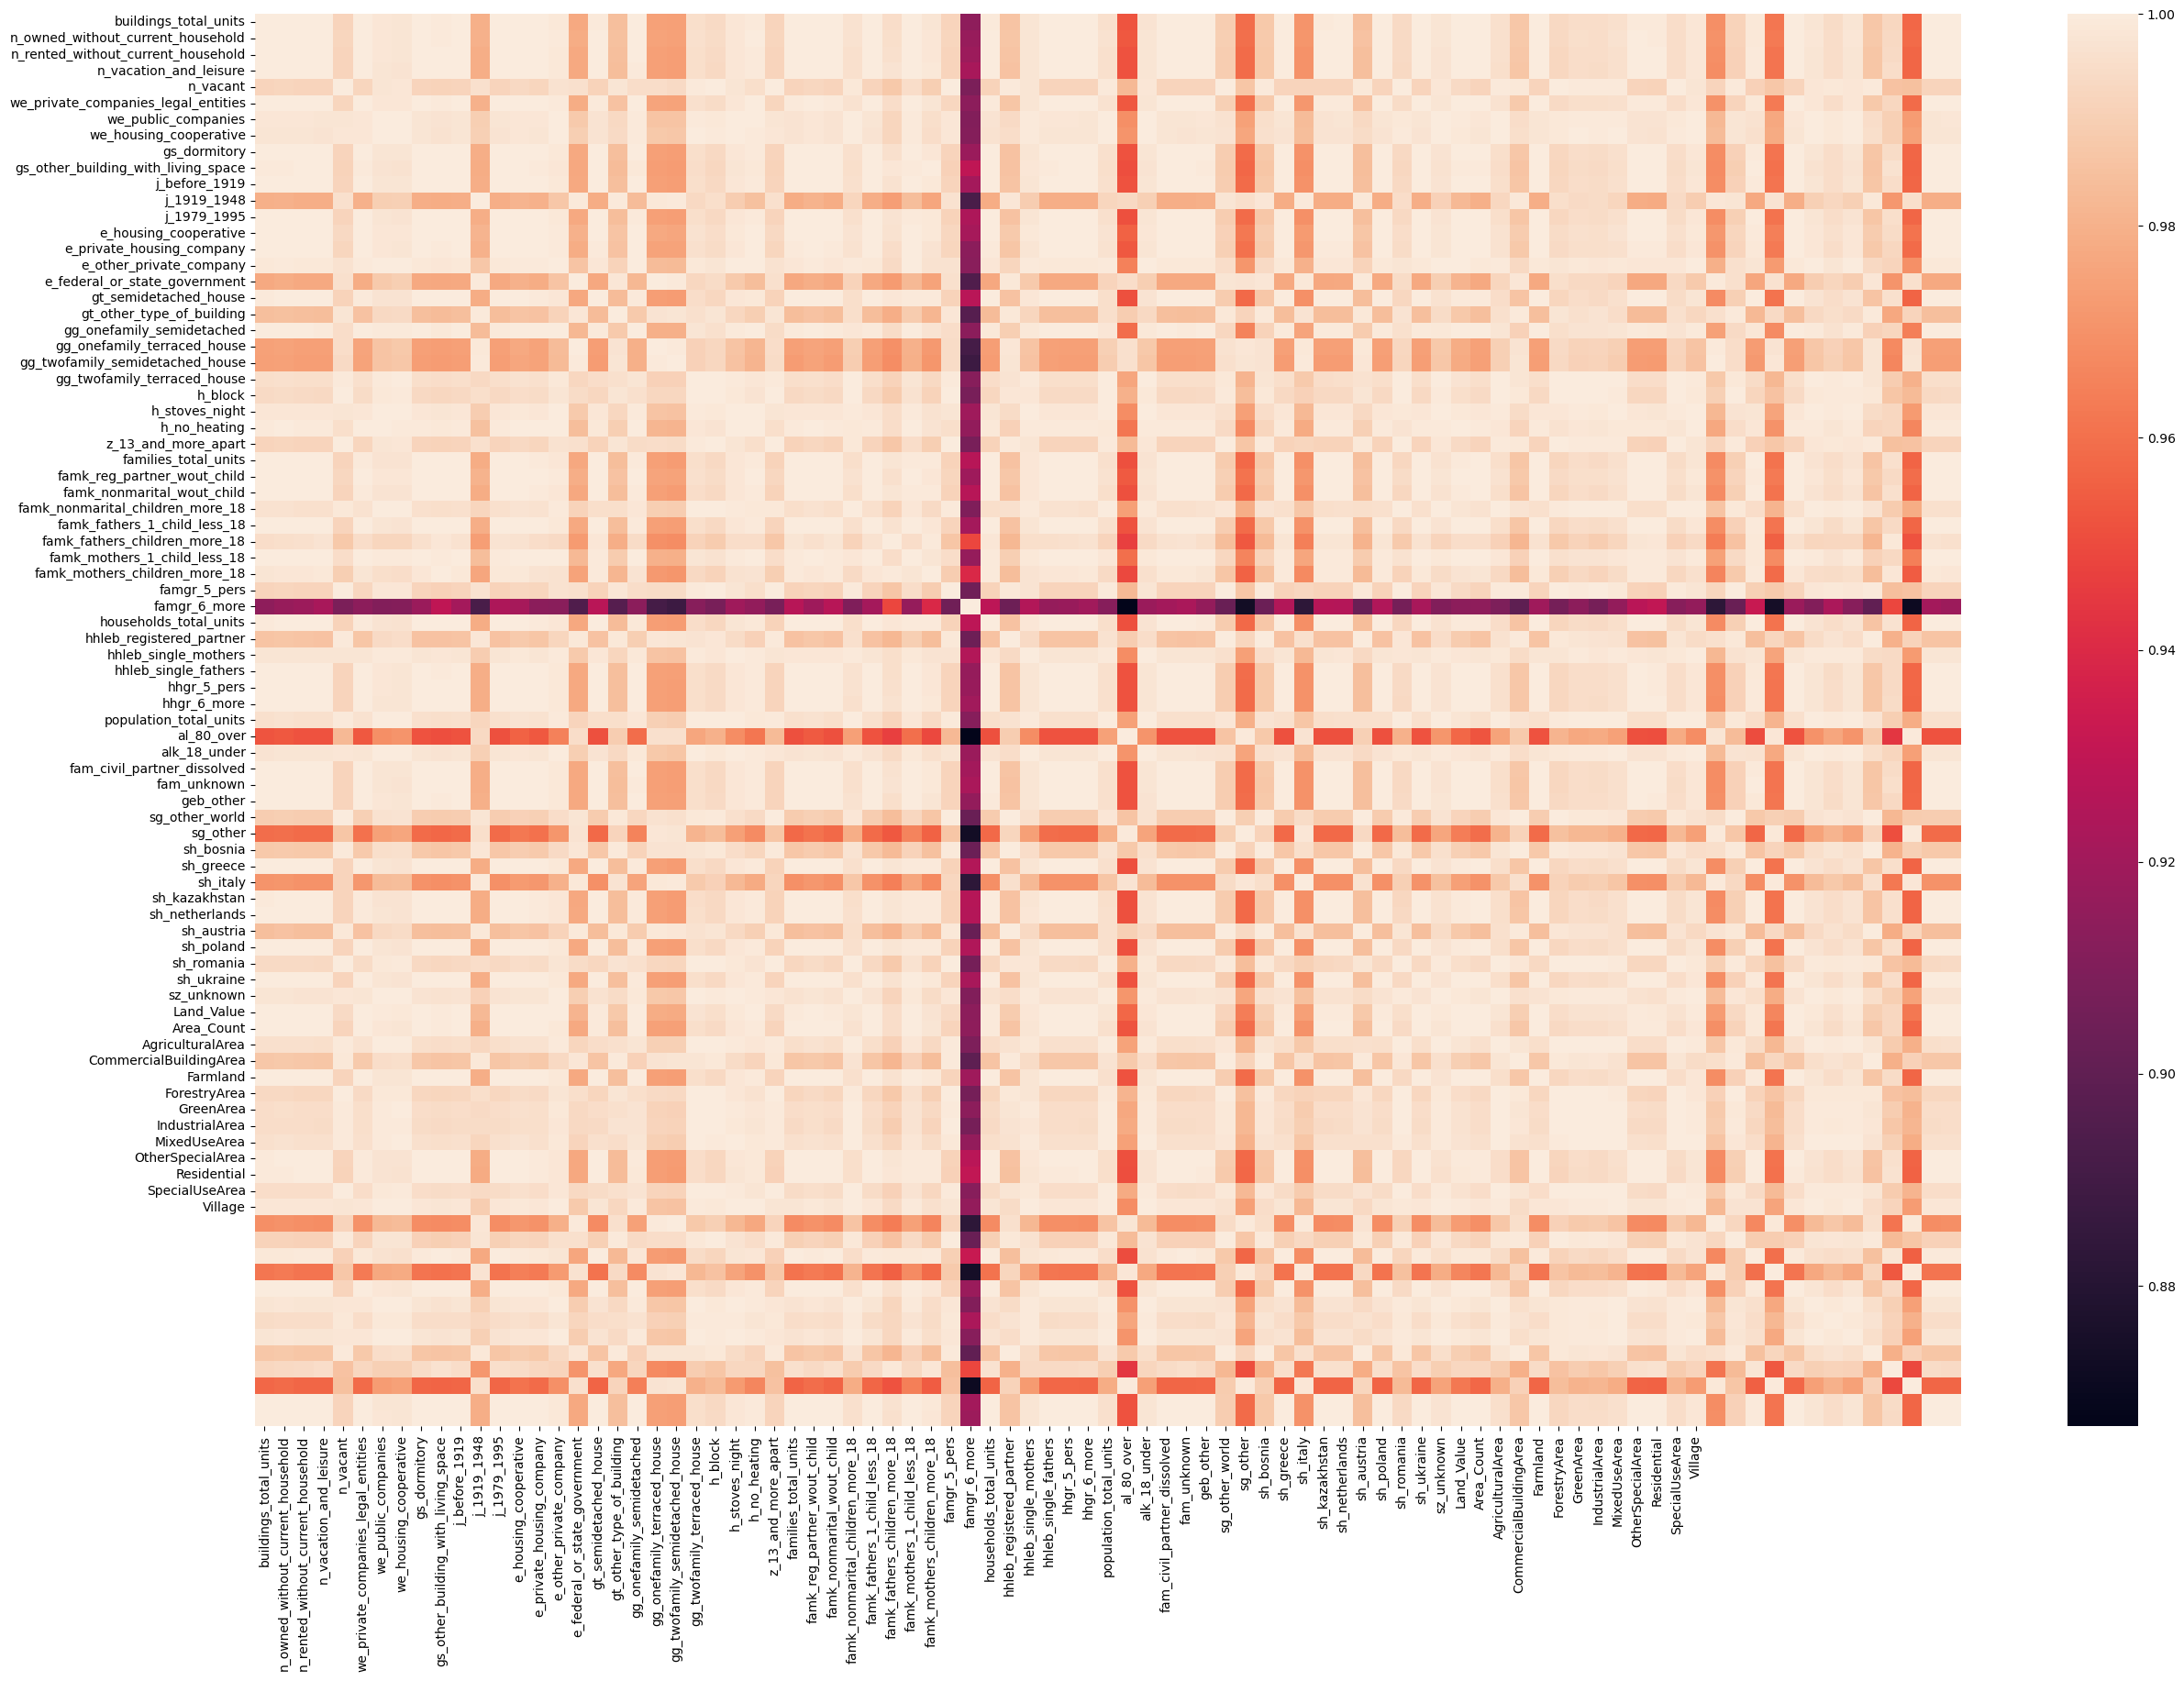

In [14]:
corr = np.corrcoef(df_bremen)


plt.figure(figsize=(30,20))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=df_bremen.columns,
        yticklabels=df_bremen.columns)

plt.show

In [15]:
df_bremen.columns

Index(['buildings_total_units', 'n_owned_without_current_household',
       'n_rented_without_current_household', 'n_vacation_and_leisure',
       'n_vacant', 'we_private_companies_legal_entities',
       'we_public_companies', 'we_housing_cooperative', 'gs_dormitory',
       'gs_other_building_with_living_space', 'j_before_1919', 'j_1919_1948',
       'j_1979_1995', 'e_housing_cooperative', 'e_private_housing_company',
       'e_other_private_company', 'e_federal_or_state_government',
       'gt_semidetached_house', 'gt_other_type_of_building',
       'gg_onefamily_semidetached', 'gg_onefamily_terraced_house',
       'gg_twofamily_semidetached_house', 'gg_twofamily_terraced_house',
       'h_block', 'h_stoves_night', 'h_no_heating', 'z_13_and_more_apart',
       'families_total_units', 'famk_reg_partner_wout_child',
       'famk_nonmarital_wout_child', 'famk_nonmarital_children_more_18',
       'famk_fathers_1_child_less_18', 'famk_fathers_children_more_18',
       'famk_mothers_1_chi

In [16]:
y = df_bremen["Land_Value"].values.reshape(-1, 1)
X = df_bremen.drop(columns = ["Land_Value"])[["buildings_total_units",
"population_total_units",
"households_total_units",
'Area_Count',
"AgriculturalArea",
"famgr_6_more",
"al_80_over"]].values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)


In [17]:
X2 = sm.add_constant(X_scaled)
est = sm.OLS(y_scaled, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     9.924
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           3.62e-08
Time:                        23:29:44   Log-Likelihood:                -99.247
No. Observations:                  87   AIC:                             212.5
Df Residuals:                      80   BIC:                             229.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -3.14e-16      0.085  -3.71e-15      1.0

d:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [18]:
scores = cross_val_score(regr, X_scaled, y_scaled, cv = 5)
scores

array([-0.04539832,  0.31480297, -0.8735156 ,  0.50128857,  0.43898193])

In [19]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.07 (+/- 1.01)


### Dresden

In [20]:
df_dresden = ls_df_cities[2].drop(columns = ["geometry", "City_Name", "City_Code", "index_right", "Neighborhood_FID", "Neighborhood_Code"])

<function matplotlib.pyplot.show(close=None, block=None)>

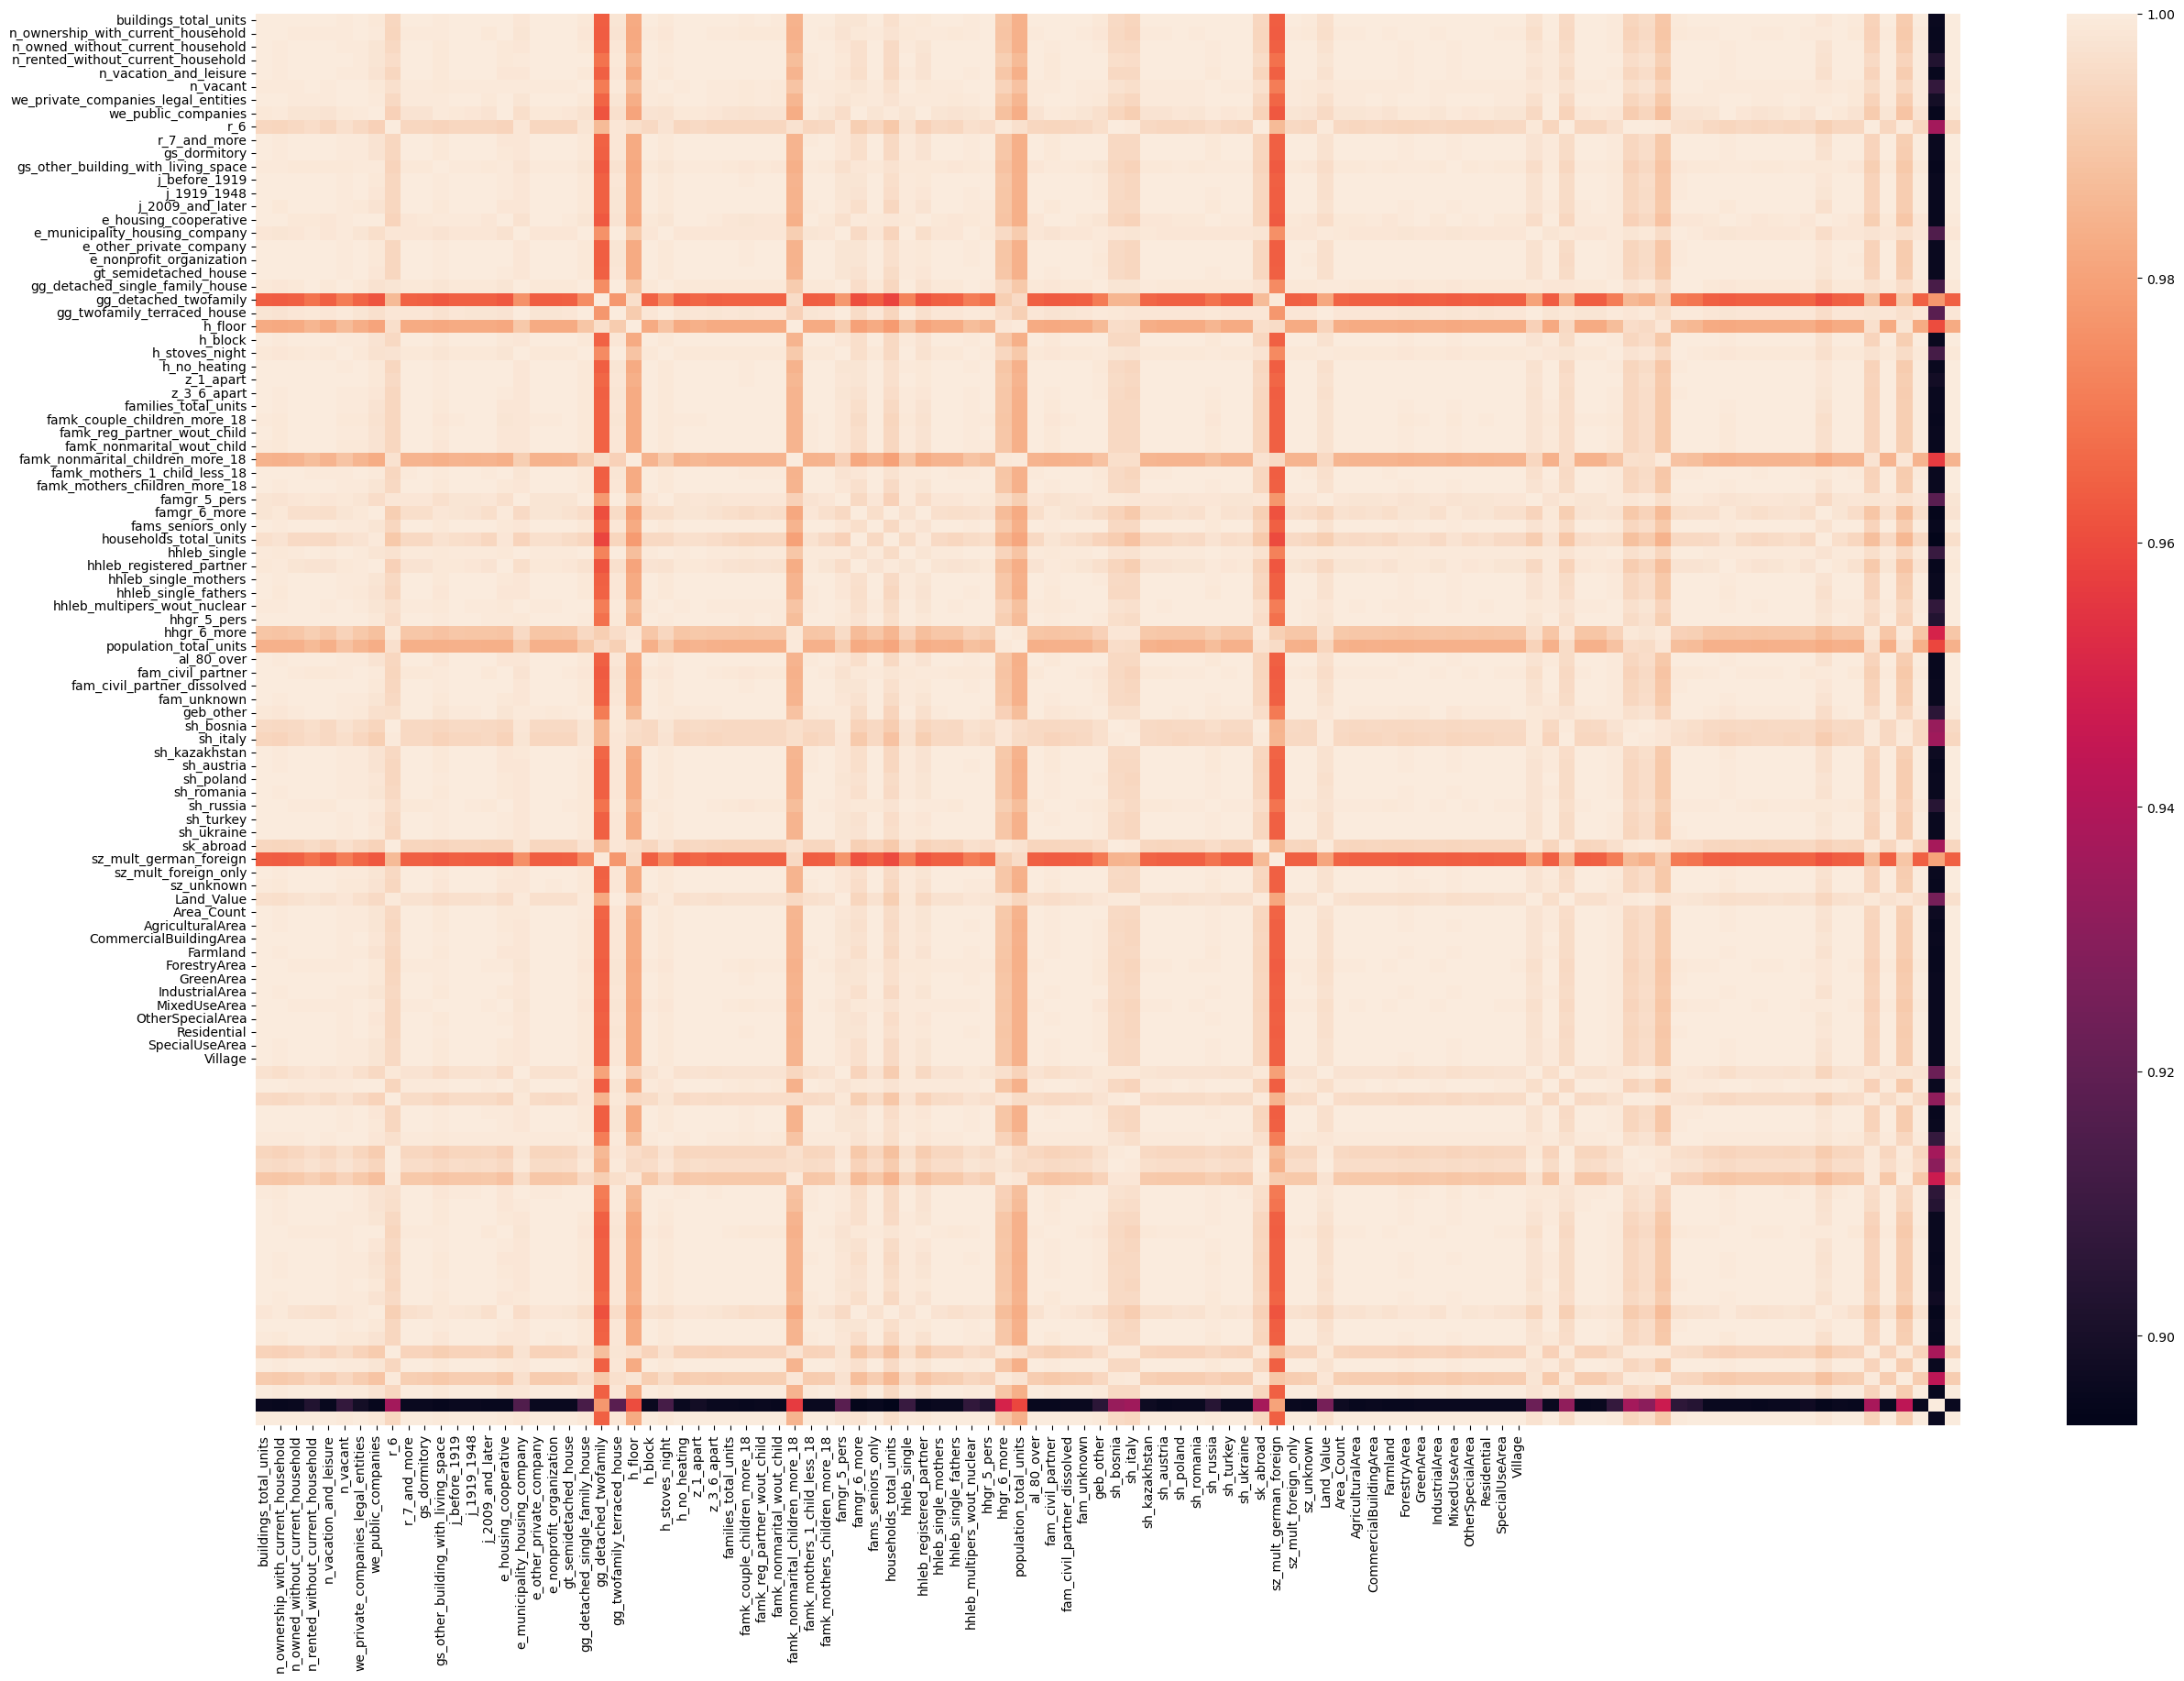

In [21]:
corr = np.corrcoef(df_dresden)


plt.figure(figsize=(30,20))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=df_dresden.columns,
        yticklabels=df_dresden.columns)

plt.show

In [22]:
df_dresden.columns

Index(['buildings_total_units', 'n_ownership_with_current_household',
       'n_owned_without_current_household',
       'n_rented_without_current_household', 'n_vacation_and_leisure',
       'n_vacant', 'we_private_companies_legal_entities',
       'we_public_companies', 'r_6', 'r_7_and_more', 'gs_dormitory',
       'gs_other_building_with_living_space', 'j_before_1919', 'j_1919_1948',
       'j_2009_and_later', 'e_housing_cooperative',
       'e_municipality_housing_company', 'e_other_private_company',
       'e_nonprofit_organization', 'gt_semidetached_house',
       'gg_detached_single_family_house', 'gg_detached_twofamily',
       'gg_twofamily_terraced_house', 'h_floor', 'h_block', 'h_stoves_night',
       'h_no_heating', 'z_1_apart', 'z_3_6_apart', 'families_total_units',
       'famk_couple_children_more_18', 'famk_reg_partner_wout_child',
       'famk_nonmarital_wout_child', 'famk_nonmarital_children_more_18',
       'famk_mothers_1_child_less_18', 'famk_mothers_children_more_

In [23]:
y = df_dresden["Land_Value"].values.reshape(-1, 1)
X = df_dresden.drop(columns = ["Land_Value"])[["buildings_total_units",
"population_total_units",
"households_total_units",
'Area_Count',
"sz_mult_german_foreign"]].values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [24]:
df_dresden

,buildings_total_units,n_ownership_with_current_household,n_owned_without_current_household,n_rented_without_current_household,n_vacation_and_leisure,n_vacant,we_private_companies_legal_entities,we_public_companies,r_6,r_7_and_more,...,CommercialBuildingArea,Farmland,ForestryArea,GreenArea,IndustrialArea,MixedUseArea,OtherSpecialArea,Residential,SpecialUseArea,Village
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
102,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
104,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [25]:
X2 = sm.add_constant(X_scaled)
est = sm.OLS(y_scaled, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     3.065
Date:                Sat, 29 Apr 2023   Prob (F-statistic):             0.0129
Time:                        23:29:45   Log-Likelihood:                -142.85
No. Observations:                 106   AIC:                             297.7
Df Residuals:                     100   BIC:                             313.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.11e-16      0.093  -1.19e-15      1.0

In [26]:
scores = cross_val_score(regr, X_scaled, y_scaled, cv = 5)
scores

array([-0.14739218, -0.16322389,  0.10778357,  0.37576426,  0.21071124])

In [27]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.08 (+/- 0.42)


### Frankfurt am Main

In [28]:
df_frankfurt = ls_df_cities[3].drop(columns = ["geometry", "City_Name", "City_Code", "Neighborhood_FID"])

<function matplotlib.pyplot.show(close=None, block=None)>

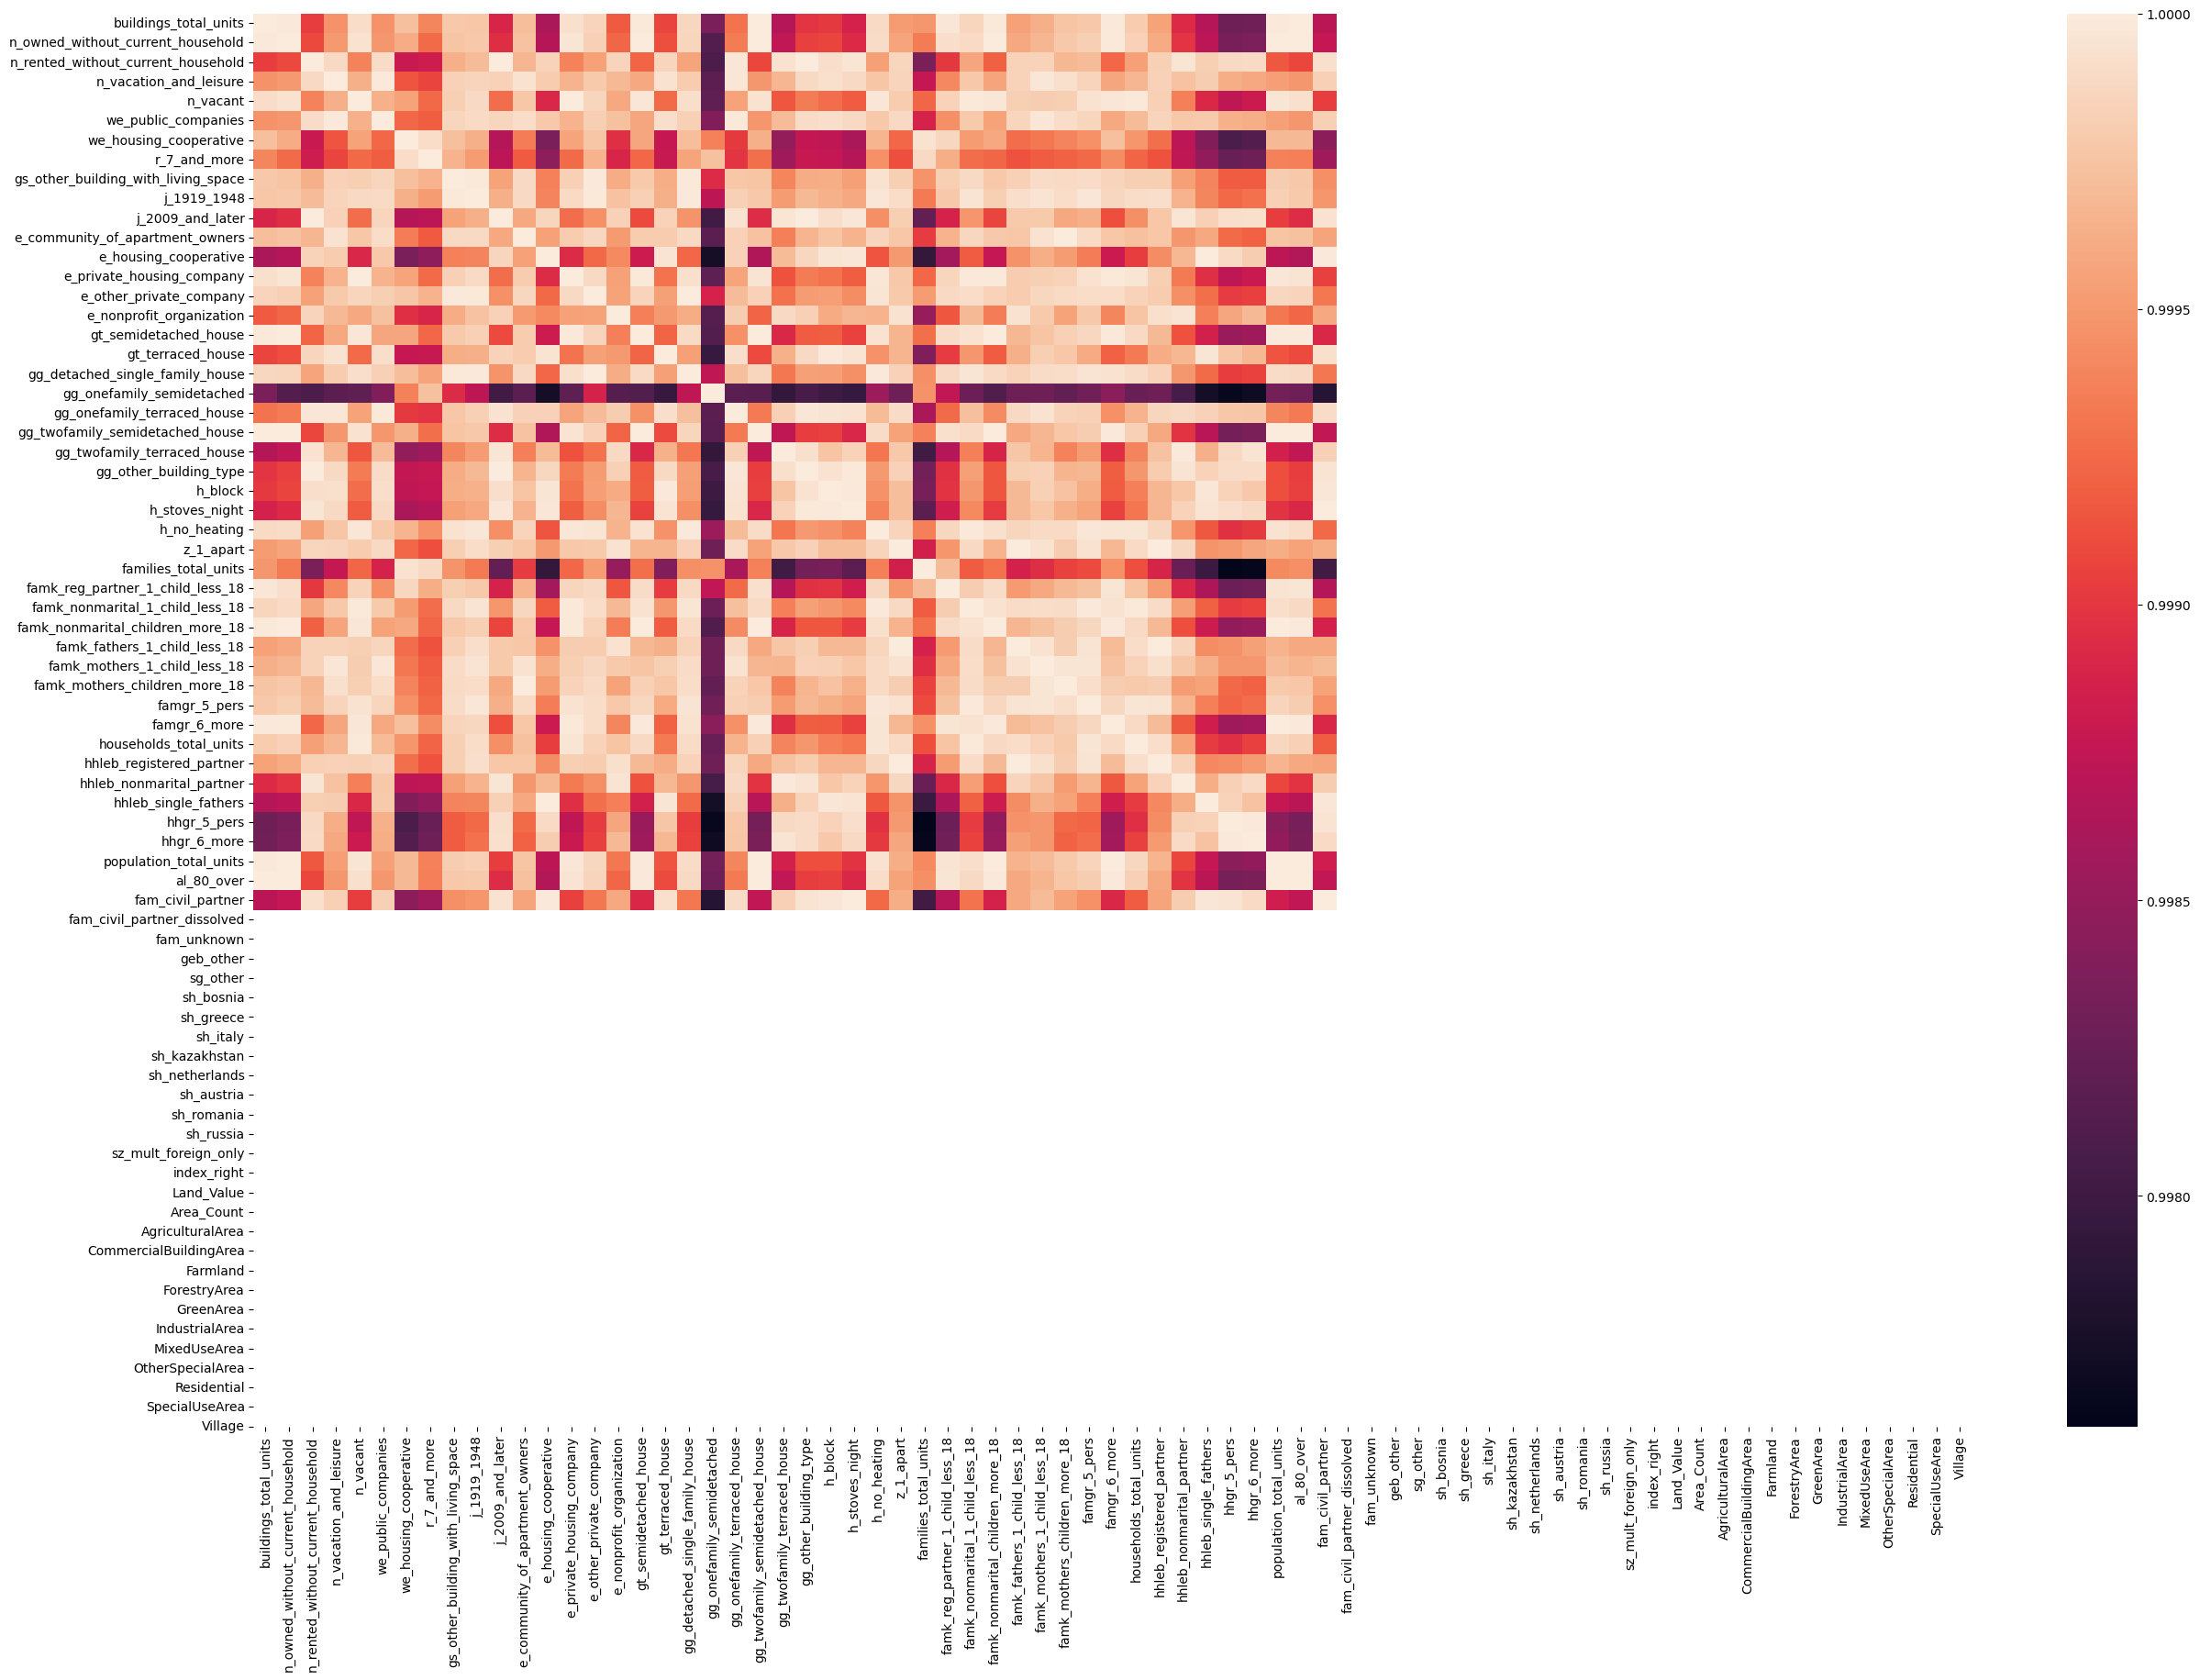

In [29]:
corr = np.corrcoef(df_frankfurt)


plt.figure(figsize=(30,20))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=df_frankfurt.columns,
        yticklabels=df_frankfurt.columns)

plt.show

In [30]:
df_frankfurt.columns

Index(['buildings_total_units', 'n_owned_without_current_household',
       'n_rented_without_current_household', 'n_vacation_and_leisure',
       'n_vacant', 'we_public_companies', 'we_housing_cooperative',
       'r_7_and_more', 'gs_other_building_with_living_space', 'j_1919_1948',
       'j_2009_and_later', 'e_community_of_apartment_owners',
       'e_housing_cooperative', 'e_private_housing_company',
       'e_other_private_company', 'e_nonprofit_organization',
       'gt_semidetached_house', 'gt_terraced_house',
       'gg_detached_single_family_house', 'gg_onefamily_semidetached',
       'gg_onefamily_terraced_house', 'gg_twofamily_semidetached_house',
       'gg_twofamily_terraced_house', 'gg_other_building_type', 'h_block',
       'h_stoves_night', 'h_no_heating', 'z_1_apart', 'families_total_units',
       'famk_reg_partner_1_child_less_18', 'famk_nonmarital_1_child_less_18',
       'famk_nonmarital_children_more_18', 'famk_fathers_1_child_less_18',
       'famk_mothers_1_chil

In [31]:
y = df_frankfurt["Land_Value"].values.reshape(-1, 1)
X = df_frankfurt.drop(columns = ["Land_Value"])[[
"e_community_of_apartment_owners"]].values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [32]:
X2 = sm.add_constant(X_scaled)
est = sm.OLS(y_scaled, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     3.277
Date:                Sat, 29 Apr 2023   Prob (F-statistic):             0.0771
Time:                        23:29:47   Log-Likelihood:                -63.619
No. Observations:                  46   AIC:                             131.2
Df Residuals:                      44   BIC:                             134.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.11e-16      0.145   7.63e-16      1.0

In [33]:
scores = cross_val_score(regr, X_scaled, y_scaled, cv = 5)
scores

array([-9.54919932e-02, -1.41663361e+00, -2.13783280e-04, -3.21803645e+00,
       -9.38767207e-04])

In [34]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.95 (+/- 2.51)


### Koeln

In [35]:
df_koeln = ls_df_cities[4].drop(columns = ["geometry", "City_Name", "City_Code", "Neighborhood_FID", "District_Name"])

<function matplotlib.pyplot.show(close=None, block=None)>

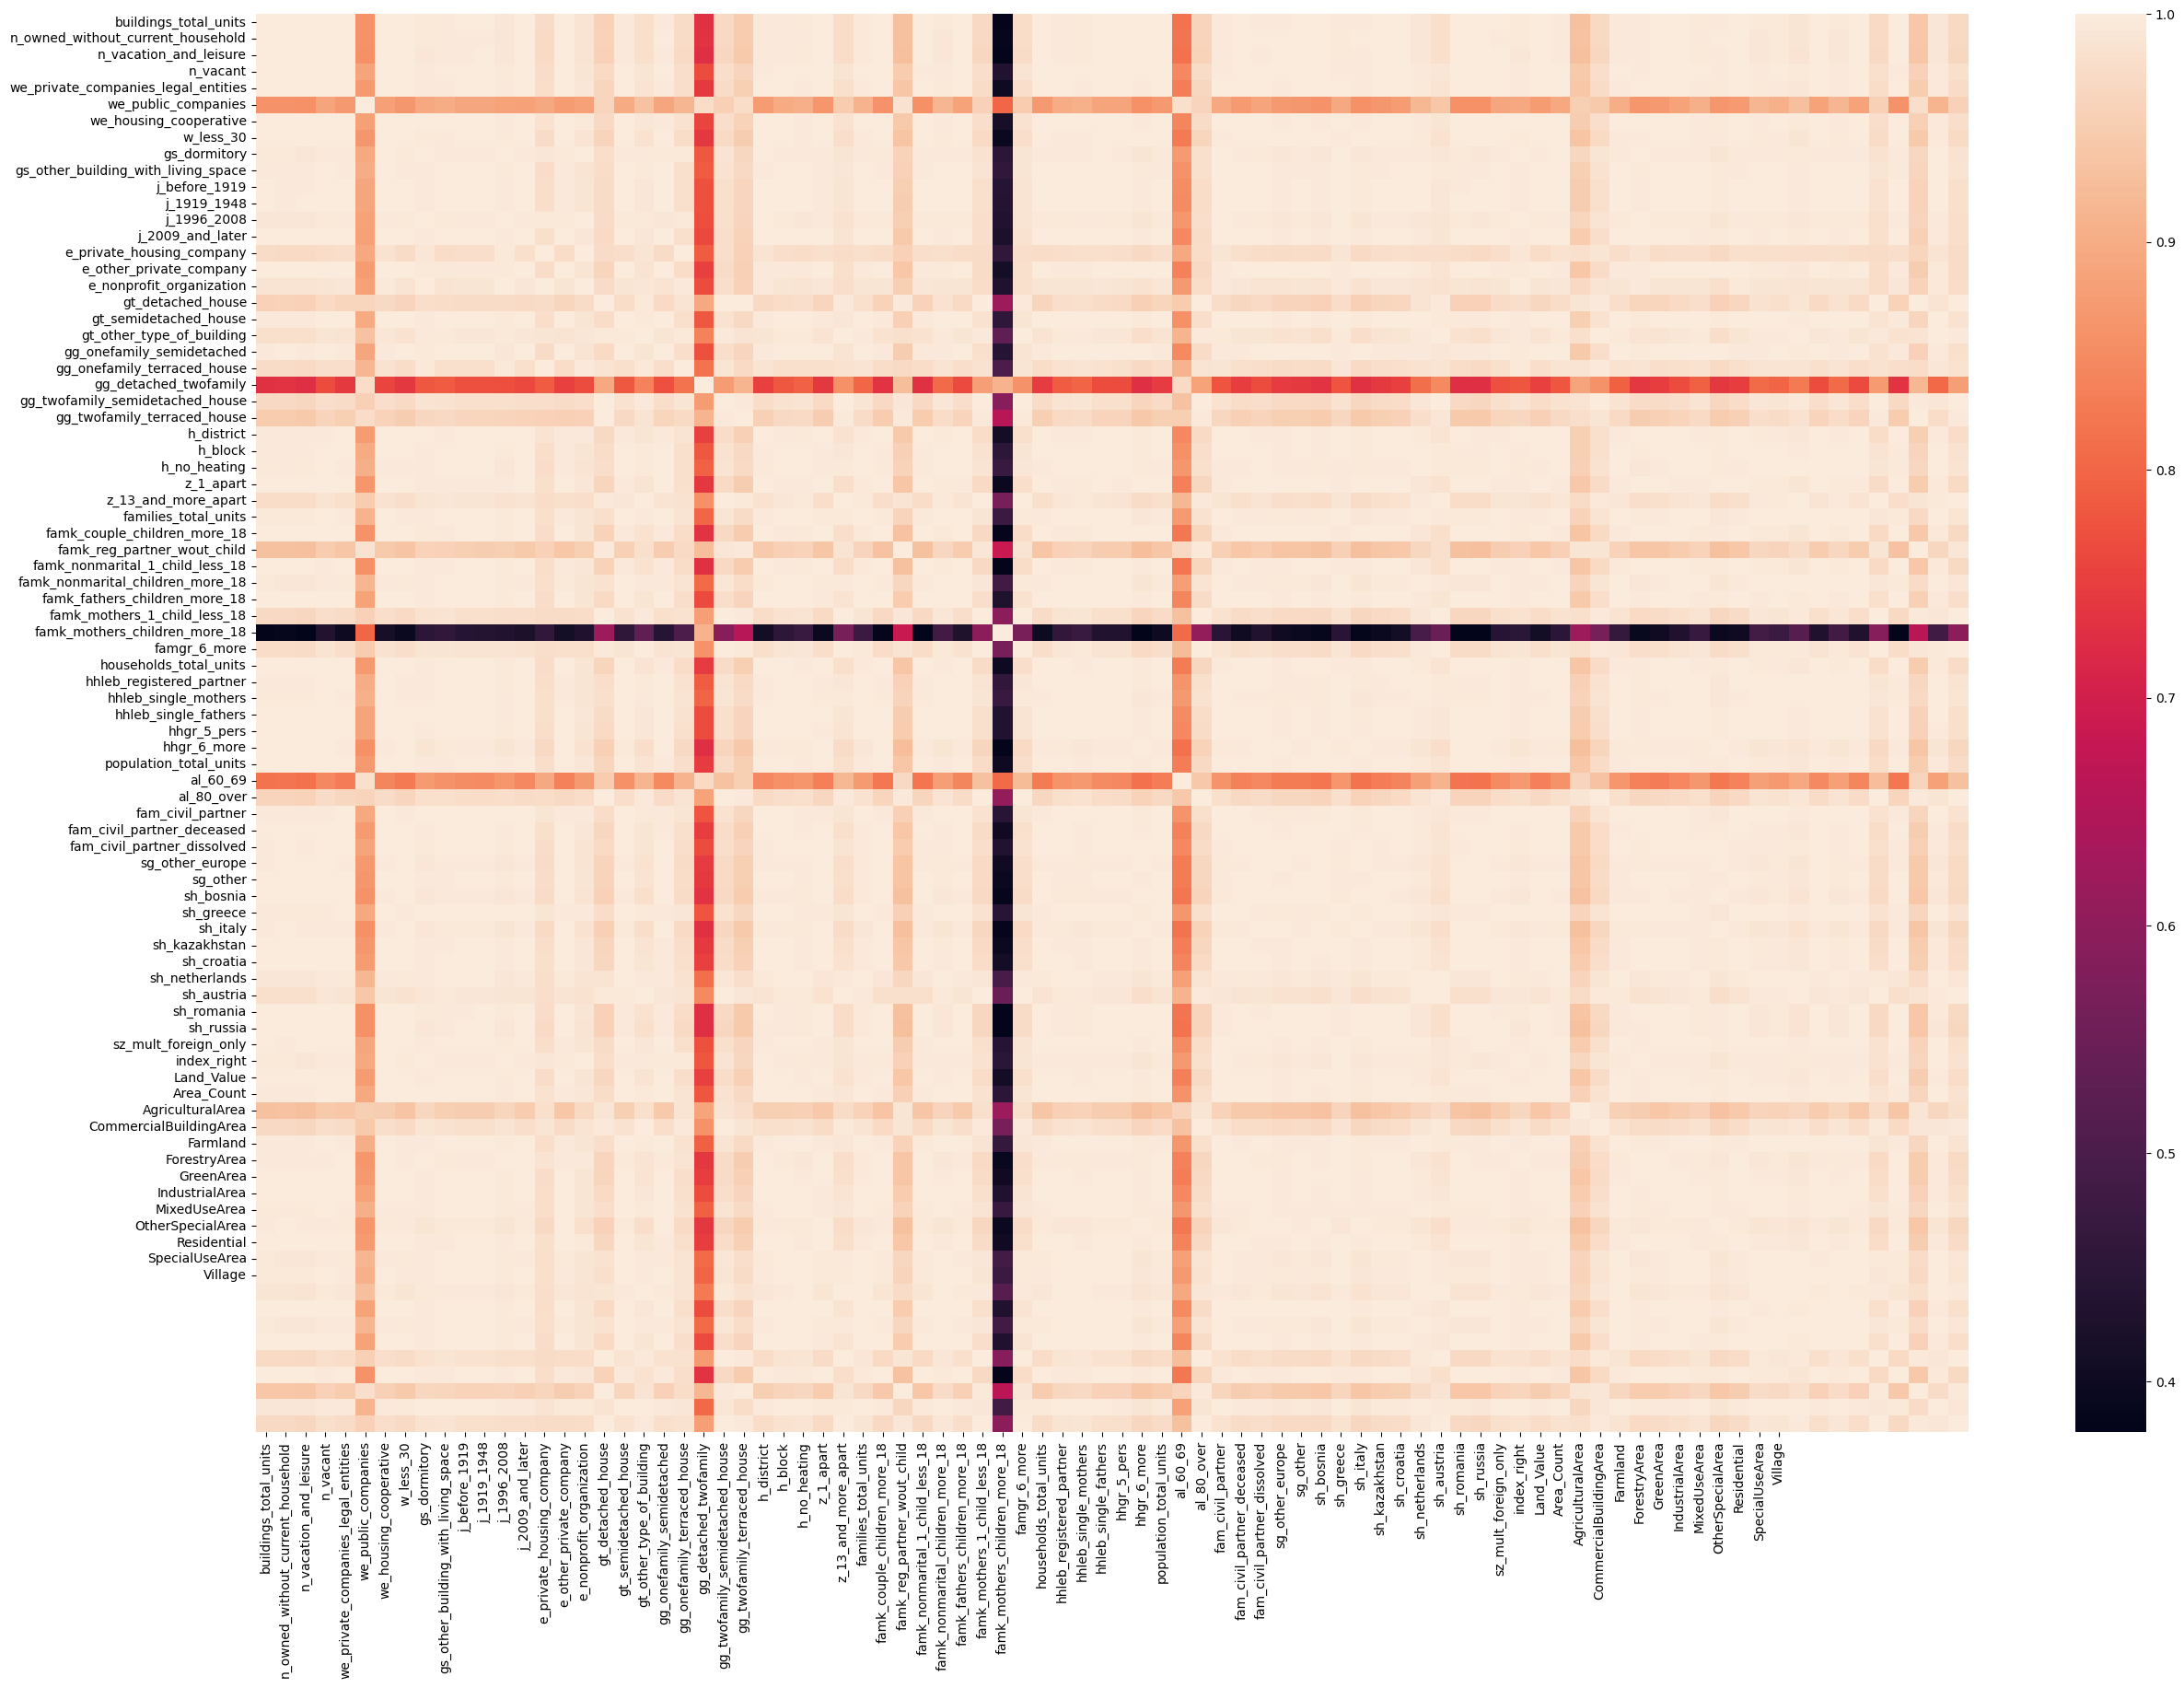

In [36]:
corr = np.corrcoef(df_koeln)


plt.figure(figsize=(30,20))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=df_koeln.columns,
        yticklabels=df_koeln.columns)

plt.show

In [37]:
df_koeln.columns

Index(['buildings_total_units', 'n_owned_without_current_household',
       'n_vacation_and_leisure', 'n_vacant',
       'we_private_companies_legal_entities', 'we_public_companies',
       'we_housing_cooperative', 'w_less_30', 'gs_dormitory',
       'gs_other_building_with_living_space', 'j_before_1919', 'j_1919_1948',
       'j_1996_2008', 'j_2009_and_later', 'e_private_housing_company',
       'e_other_private_company', 'e_nonprofit_organization',
       'gt_detached_house', 'gt_semidetached_house',
       'gt_other_type_of_building', 'gg_onefamily_semidetached',
       'gg_onefamily_terraced_house', 'gg_detached_twofamily',
       'gg_twofamily_semidetached_house', 'gg_twofamily_terraced_house',
       'h_district', 'h_block', 'h_no_heating', 'z_1_apart',
       'z_13_and_more_apart', 'families_total_units',
       'famk_couple_children_more_18', 'famk_reg_partner_wout_child',
       'famk_nonmarital_1_child_less_18', 'famk_nonmarital_children_more_18',
       'famk_fathers_childr

In [38]:
y = df_koeln["Land_Value"].values.reshape(-1, 1)
X = df_koeln.drop(columns = ["Land_Value"])[["buildings_total_units",
"al_60_69",
"we_public_companies",
'famk_mothers_children_more_18',
"gg_detached_twofamily"]].values #'hhtyp_multiplepers_wout_nuclear',

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [39]:
X2 = sm.add_constant(X_scaled)
est = sm.OLS(y_scaled, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     21.33
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           3.35e-08
Time:                        23:29:49   Log-Likelihood:                -104.20
No. Observations:                  86   AIC:                             214.4
Df Residuals:                      83   BIC:                             221.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.163e-17      0.089  -4.67e-16      1.0

d:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [40]:
scores = cross_val_score(regr, X_scaled, y_scaled, cv = 5)
scores

array([ 0.19339973, -0.1477603 , -0.0784311 , -0.34665845, -0.32122059])

In [41]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.14 (+/- 0.39)
